In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings as wr
wr.filterwarnings(action="ignore")
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import mlflow.xgboost
import xgboost as xgb
from xgboost import XGBClassifier


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Carga de datos</h1>
</div>

We are merging multiple datasets 

In [3]:
account = pd.read_csv("Data/Customer Profiles/account_activity.csv")
customer = pd.read_csv("Data/Customer Profiles/customer_data.csv")
fraud = pd.read_csv("Data/Fraudulent Patterns/fraud_indicators.csv")
suspision = pd.read_csv("Data/Fraudulent Patterns/suspicious_activity.csv")
merchant = pd.read_csv("Data/Merchant Information/merchant_data.csv")
tran_cat = pd.read_csv("Data/Merchant Information/transaction_category_labels.csv")
amount = pd.read_csv("Data/Transaction Amounts/amount_data.csv")
anamoly = pd.read_csv("Data/Transaction Amounts/anomaly_scores.csv")
tran_data = pd.read_csv("Data/Transaction Data/transaction_metadata.csv")
tran_rec = pd.read_csv("Data/Transaction Data/transaction_records.csv")

data = [account,customer,fraud,suspision,merchant,tran_cat,amount,anamoly,tran_data,tran_rec]

for df in data:
    print(df.head())

   CustomerID  AccountBalance   LastLogin
0        1001     9507.272060  2022-01-01
1        1002     7408.704536  2022-01-02
2        1003     1715.321989  2022-01-03
3        1004     3101.509134  2022-01-04
4        1005     5405.766914  2022-01-05
   CustomerID           Name  Age       Address
0        1001  Customer 1001   54  Address 1001
1        1002  Customer 1002   35  Address 1002
2        1003  Customer 1003   40  Address 1003
3        1004  Customer 1004   30  Address 1004
4        1005  Customer 1005   46  Address 1005
   TransactionID  FraudIndicator
0              1               0
1              2               0
2              3               0
3              4               0
4              5               0
   CustomerID  SuspiciousFlag
0        1001               0
1        1002               0
2        1003               0
3        1004               0
4        1005               0
   MerchantID   MerchantName       Location
0        2001  Merchant 2001  Location

In [4]:
costumer_data = pd.merge(customer, account, on='CustomerID')
costumer_data = pd.merge(costumer_data, suspision, on='CustomerID')
costumer_data

,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1001,Customer 1001,54,Address 1001,9507.272060,2022-01-01,0
1,1002,Customer 1002,35,Address 1002,7408.704536,2022-01-02,0
2,1003,Customer 1003,40,Address 1003,1715.321989,2022-01-03,0
3,1004,Customer 1004,30,Address 1004,3101.509134,2022-01-04,0
4,1005,Customer 1005,46,Address 1005,5405.766914,2022-01-05,0
...,...,...,...,...,...,...,...
995,1996,Customer 1996,33,Address 1996,8523.485163,2024-09-22,0
996,1997,Customer 1997,58,Address 1997,9255.451757,2024-09-23,0
997,1998,Customer 1998,25,Address 1998,9148.652759,2024-09-24,0
998,1999,Customer 1999,57,Address 1999,7376.854107,2024-09-25,0


In [5]:
transaction_data1 = pd.merge(fraud, tran_cat, on="TransactionID")
transaction_data2 = pd.merge(amount, anamoly, on="TransactionID")
transaction_data3 = pd.merge(tran_data, tran_rec, on="TransactionID")
transaction_data = pd.merge(transaction_data1, transaction_data2,on="TransactionID")
transaction_data = pd.merge(transaction_data, transaction_data3,on="TransactionID")
transaction_data

,TransactionID,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID
0,1,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952
1,2,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027
2,3,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955
3,4,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796
4,5,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946
...,...,...,...,...,...,...,...,...,...
995,996,0,Food,89.457059,0.266778,2022-02-11 11:00:00,2150,19.876750,1411
996,997,0,Retail,47.958030,0.512483,2022-02-11 12:00:00,2888,96.299792,1566
997,998,0,Food,64.210046,0.367740,2022-02-11 13:00:00,2037,75.164459,1654
998,999,0,Travel,64.684167,0.960364,2022-02-11 14:00:00,2629,93.633040,1928


In [6]:
data = pd.merge(transaction_data, costumer_data,on="CustomerID")
data

,TransactionID,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,MerchantID,Amount,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,0,Other,79.413607,0.686699,2022-01-01 00:00:00,2701,55.530334,1952,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,0,Online,12.053087,0.081749,2022-01-01 01:00:00,2070,12.881180,1027,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0
2,3,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,2238,50.176322,1955,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0
3,4,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,2879,41.634001,1796,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0
4,5,0,Other,54.051618,0.034059,2022-01-01 04:00:00,2966,78.122853,1946,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,Food,89.457059,0.266778,2022-02-11 11:00:00,2150,19.876750,1411,Customer 1411,19,Address 1411,1290.323059,2023-02-15,0
996,997,0,Retail,47.958030,0.512483,2022-02-11 12:00:00,2888,96.299792,1566,Customer 1566,39,Address 1566,7067.831609,2023-07-20,0
997,998,0,Food,64.210046,0.367740,2022-02-11 13:00:00,2037,75.164459,1654,Customer 1654,51,Address 1654,9088.738359,2023-10-16,0
998,999,0,Travel,64.684167,0.960364,2022-02-11 14:00:00,2629,93.633040,1928,Customer 1928,60,Address 1928,9352.655675,2024-07-16,0


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Exploración de datos</h1>
</div>


In [7]:
print(" Información general del dataset:")
data.info()

print("\n Dimensiones del dataset (filas, columnas):")
print(data.shape)

print("\n Estadísticas descriptivas del dataset:")
print(data.describe())


 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionID      1000 non-null   int64  
 1   FraudIndicator     1000 non-null   int64  
 2   Category           1000 non-null   object 
 3   TransactionAmount  1000 non-null   float64
 4   AnomalyScore       1000 non-null   float64
 5   Timestamp          1000 non-null   object 
 6   MerchantID         1000 non-null   int64  
 7   Amount             1000 non-null   float64
 8   CustomerID         1000 non-null   int64  
 9   Name               1000 non-null   object 
 10  Age                1000 non-null   int64  
 11  Address            1000 non-null   object 
 12  AccountBalance     1000 non-null   float64
 13  LastLogin          1000 non-null   object 
 14  SuspiciousFlag     1000 non-null   int64  
dtypes: float64(4), int64(6), object(5)
memo

In [8]:
# Columnas categóricas
categorical_columns = ["FraudIndicator", 'SuspiciousFlag', "Category", "Name", "Address", "LastLogin"]

# Filtrar columnas numéricas
numeric_columns = ['TransactionID', 'TransactionAmount', 'AnomalyScore', 'MerchantID', 'Amount', 'CustomerID', 'Age', 'AccountBalance']

## Countplot de variables categoricas

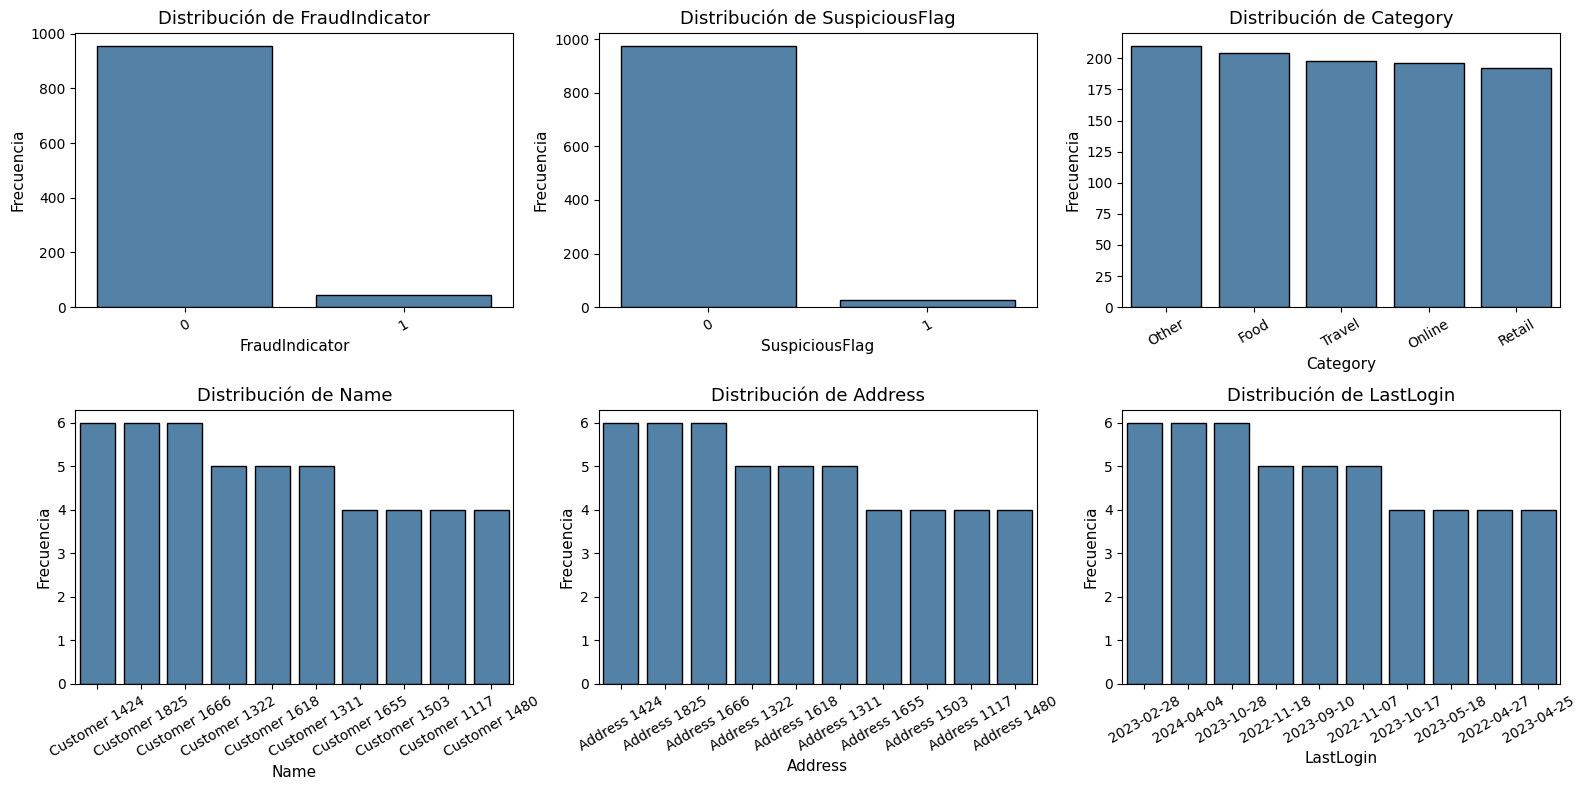

In [9]:
# Definir número de columnas y calcular filas necesarias
ncols = 3
nrows = (len(categorical_columns) + ncols - 1) // ncols

# Crear figura y ejes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

# Graficar cada variable
for idx, column in enumerate(categorical_columns):
    top_10_values = data[column].value_counts().head(10)
    sns.countplot(
        x=column,
        data=data,
        order=top_10_values.index,
        color="steelblue",
        edgecolor='black',
        ax=axes[idx]
    )
    axes[idx].set_title(f'Distribución de {column}', fontsize=13)
    axes[idx].set_xlabel(column, fontsize=11)
    axes[idx].set_ylabel('Frecuencia', fontsize=11)
    axes[idx].tick_params(axis='x', rotation=30)

# Eliminar subplots vacíos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Histplot para variables numéricas

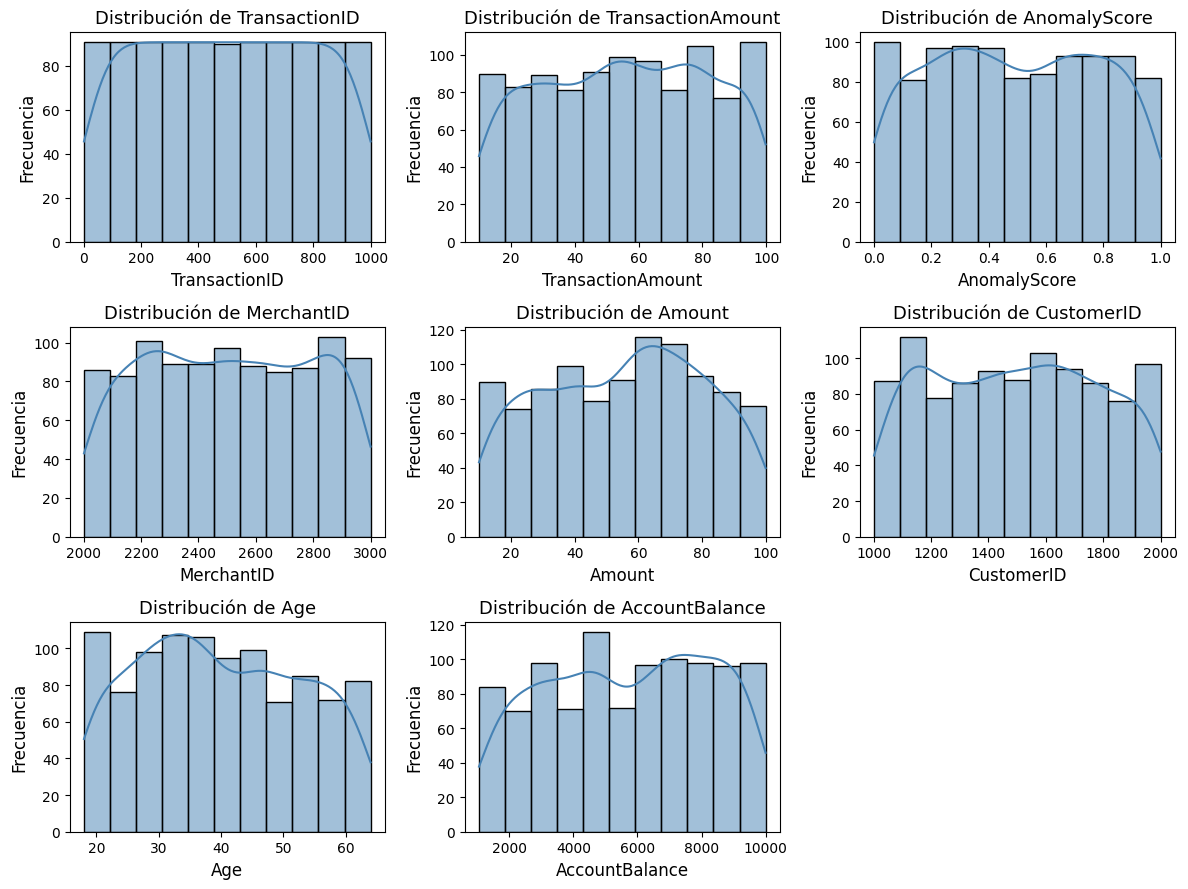

In [10]:
# Crear figura y subplots
fig, axes = plt.subplots(
    nrows=(len(numeric_columns) + 2) // 3,  # Ajuste pequeño para 3 columnas
    ncols=3,
    figsize=(12, 9)
)

# Aplanar el array de ejes
axes = axes.flatten()

# Recorrer variables numéricas
for idx, column in enumerate(numeric_columns):
    sns.histplot(
        data[column], 
        kde=True, 
        color="steelblue",
        ax=axes[idx]  
    )
    axes[idx].set_title(f'Distribución de {column}', fontsize=13)
    axes[idx].set_xlabel(column, fontsize=12)
    axes[idx].set_ylabel('Frecuencia', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=0)

# Eliminar subplots vacíos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espacio
plt.tight_layout()
plt.show()


## BoxPlot de variables numericas

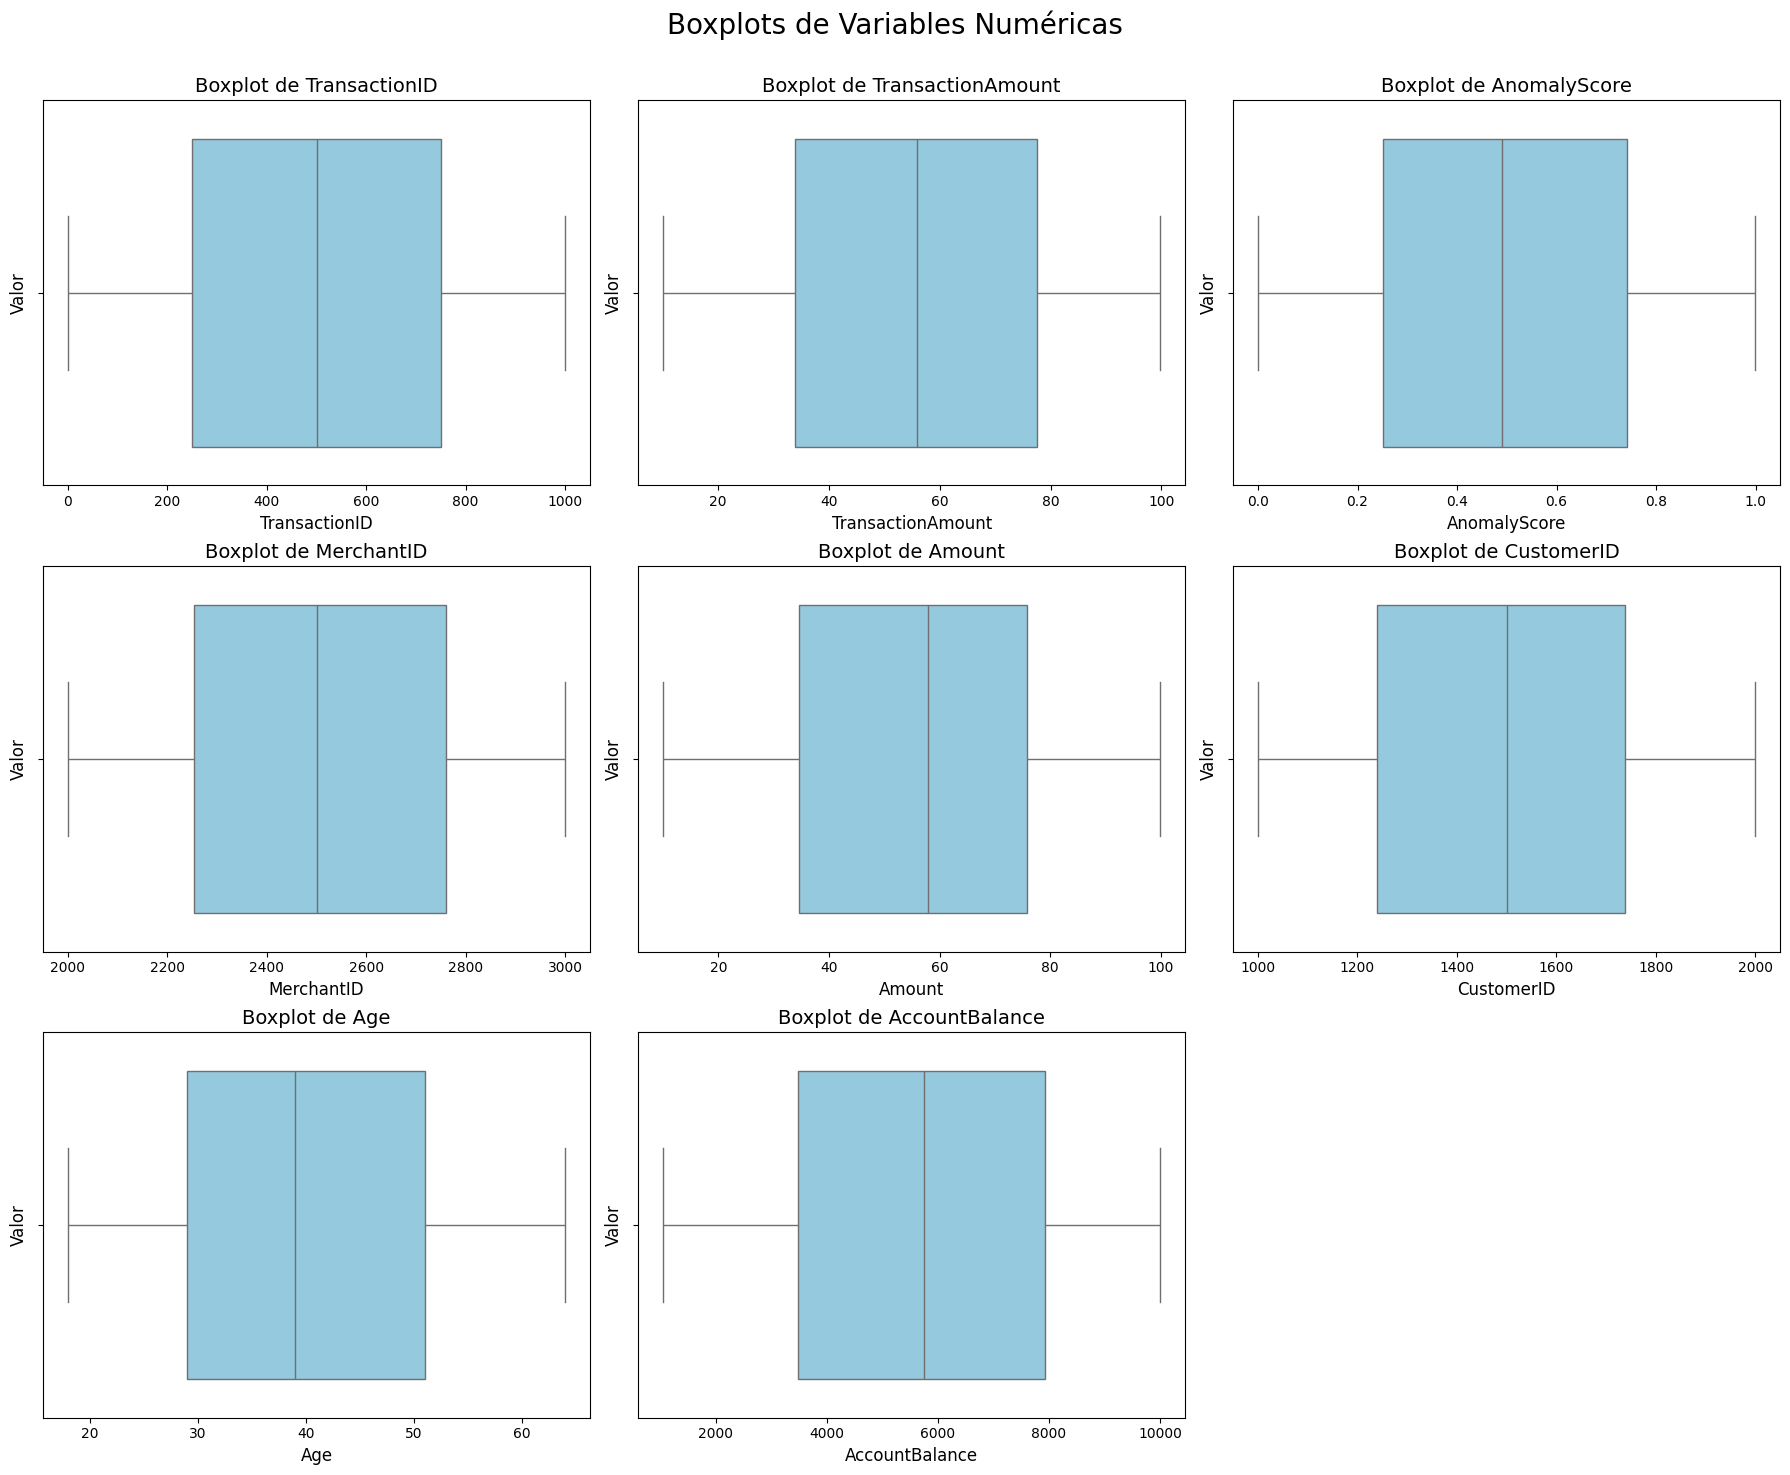

In [11]:
num_cols = len(numeric_columns)

# Definir cantidad de filas y columnas
ncols = 3  # Dos boxplots por fila
nrows = (num_cols + ncols - 1) // ncols  # Redondeo para arriba

# Crear figura y subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()  # Aplanar para fácil iteración

# Dibujar los boxplots
for idx, column in enumerate(numeric_columns):
    sns.boxplot(
        x=data[column],
        color='skyblue',
        ax=axes[idx]
    )
    axes[idx].set_title(f'Boxplot de {column}', fontsize=14)
    axes[idx].set_xlabel(column, fontsize=12)
    axes[idx].set_ylabel('Valor', fontsize=12)

# Si sobran ejes vacíos, eliminarlos
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Boxplots de Variables Numéricas', fontsize=20)
plt.show()


## Matriz de correlación a variables numericas

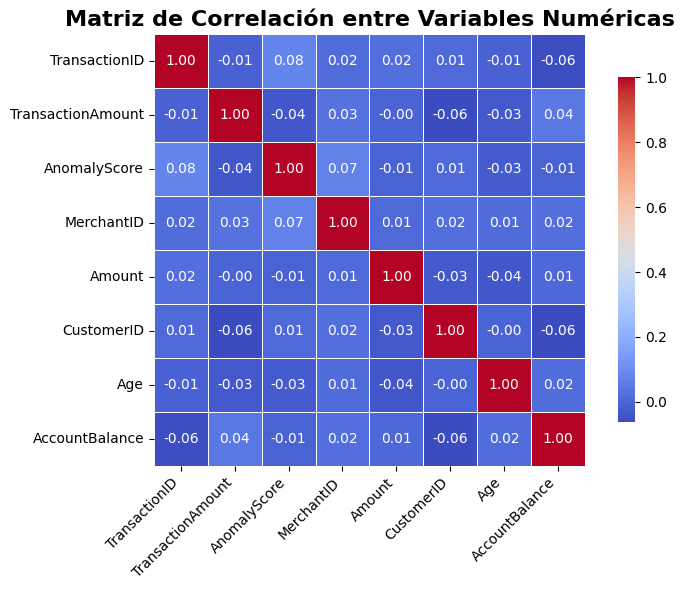

In [12]:
# Filtrar solo las columnas numéricas
numeric_df = data[numeric_columns]

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,            # Mostrar los números
    cmap='coolwarm',        # Mantener la misma paleta
    fmt=".2f",              # Formato de los números
    linewidths=0.5,         # Separación entre cuadros
    linecolor='white',      # Color de las líneas
    square=True,            # Que cada celda sea cuadrada
    cbar_kws={"shrink": .8} # Hacer la barra de colores más pequeña
)
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para que no se superpongan
plt.yticks(rotation=0)               # Mantener las etiquetas de Y horizontales
plt.tight_layout()
plt.show()


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Feature Engineering</h1>
</div>


Feature Engineering consiste en seleccionar y transformar las variables que se utilizarán en el modelo. Tambien normalizar variables, manipular datos categóricos y crear nuevas variables a partir de las existentes

In [13]:
# Dropping the columns as of now they are not mush corelated & also wouldn't damper the performance of model
columns_to_be_dropped = ['TransactionID','MerchantID','CustomerID','Name', 'Age', 'Address']
data1 = data.drop(columns_to_be_dropped, axis=1)
data1.head()

,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,Amount,AccountBalance,LastLogin,SuspiciousFlag
0,0,Other,79.413607,0.686699,2022-01-01 00:00:00,55.530334,2869.689912,2024-08-09,0
1,0,Online,12.053087,0.081749,2022-01-01 01:00:00,12.881180,9527.947107,2022-01-27,0
2,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,50.176322,9288.355525,2024-08-12,0
3,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,41.634001,5588.049942,2024-03-06,0
4,0,Other,54.051618,0.034059,2022-01-01 04:00:00,78.122853,7324.785332,2024-08-03,0


In [14]:
data1['FraudIndicator'].value_counts(), data1['SuspiciousFlag'].value_counts(), data1['Category'].value_counts()

(FraudIndicator
 0    955
 1     45
 Name: count, dtype: int64,
 SuspiciousFlag
 0    975
 1     25
 Name: count, dtype: int64,
 Category
 Other     210
 Food      204
 Travel    198
 Online    196
 Retail    192
 Name: count, dtype: int64)

In [15]:
# Using Feature Engineering Creating two Columns
# Hour of Transaction = hour
# Gap between the day of transaction and last login in days = gap
#Converting TimeStamp to datetime format
if pd.api.types.is_datetime64_any_dtype(data['Timestamp']):
    print("The 'Timestamp' column is already in datetime format.")
else:
    print("The 'Timestamp' column is not in datetime format. Converting it now.")
    data1['Timestamp1'] = pd.to_datetime(data1['Timestamp'])

print(data1.dtypes)

The 'Timestamp' column is not in datetime format. Converting it now.
FraudIndicator                int64
Category                     object
TransactionAmount           float64
AnomalyScore                float64
Timestamp                    object
Amount                      float64
AccountBalance              float64
LastLogin                    object
SuspiciousFlag                int64
Timestamp1           datetime64[ns]
dtype: object


In [16]:
data1['Hour'] = data1['Timestamp1'].dt.hour
data1['LastLogin'] = pd.to_datetime(data1['LastLogin'])
data1['gap'] = (data1['Timestamp1'] - data1['LastLogin']).dt.days.abs()

data1.head()

,FraudIndicator,Category,TransactionAmount,AnomalyScore,Timestamp,Amount,AccountBalance,LastLogin,SuspiciousFlag,Timestamp1,Hour,gap
0,0,Other,79.413607,0.686699,2022-01-01 00:00:00,55.530334,2869.689912,2024-08-09,0,2022-01-01 00:00:00,0,951
1,0,Online,12.053087,0.081749,2022-01-01 01:00:00,12.881180,9527.947107,2022-01-27,0,2022-01-01 01:00:00,1,26
2,0,Travel,33.310357,0.023857,2022-01-01 02:00:00,50.176322,9288.355525,2024-08-12,0,2022-01-01 02:00:00,2,954
3,0,Travel,46.121117,0.876994,2022-01-01 03:00:00,41.634001,5588.049942,2024-03-06,0,2022-01-01 03:00:00,3,795
4,0,Other,54.051618,0.034059,2022-01-01 04:00:00,78.122853,7324.785332,2024-08-03,0,2022-01-01 04:00:00,4,945


In [17]:
# Se eliminan las columnas que no son relevantes y se separa la variable objetivo en la variable Y
X = data1.drop(['FraudIndicator','Timestamp','Timestamp1','LastLogin'],axis=1)
Y = data1['FraudIndicator']

In [18]:
# Utiliza LabelEncoder para transformar valores categóricos (como texto) en números
label_encoder = LabelEncoder()
X['Category'] = label_encoder.fit_transform(X['Category'])
X

,Category,TransactionAmount,AnomalyScore,Amount,AccountBalance,SuspiciousFlag,Hour,gap
0,2,79.413607,0.686699,55.530334,2869.689912,0,0,951
1,1,12.053087,0.081749,12.881180,9527.947107,0,1,26
2,4,33.310357,0.023857,50.176322,9288.355525,0,2,954
3,4,46.121117,0.876994,41.634001,5588.049942,0,3,795
4,2,54.051618,0.034059,78.122853,7324.785332,0,4,945
...,...,...,...,...,...,...,...,...
995,0,89.457059,0.266778,19.876750,1290.323059,0,11,369
996,3,47.958030,0.512483,96.299792,7067.831609,0,12,524
997,0,64.210046,0.367740,75.164459,9088.738359,0,13,612
998,4,64.684167,0.960364,93.633040,9352.655675,0,14,886


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Normalización de datos</h1>
</div>

<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Balanceo de datos</h1>
</div>

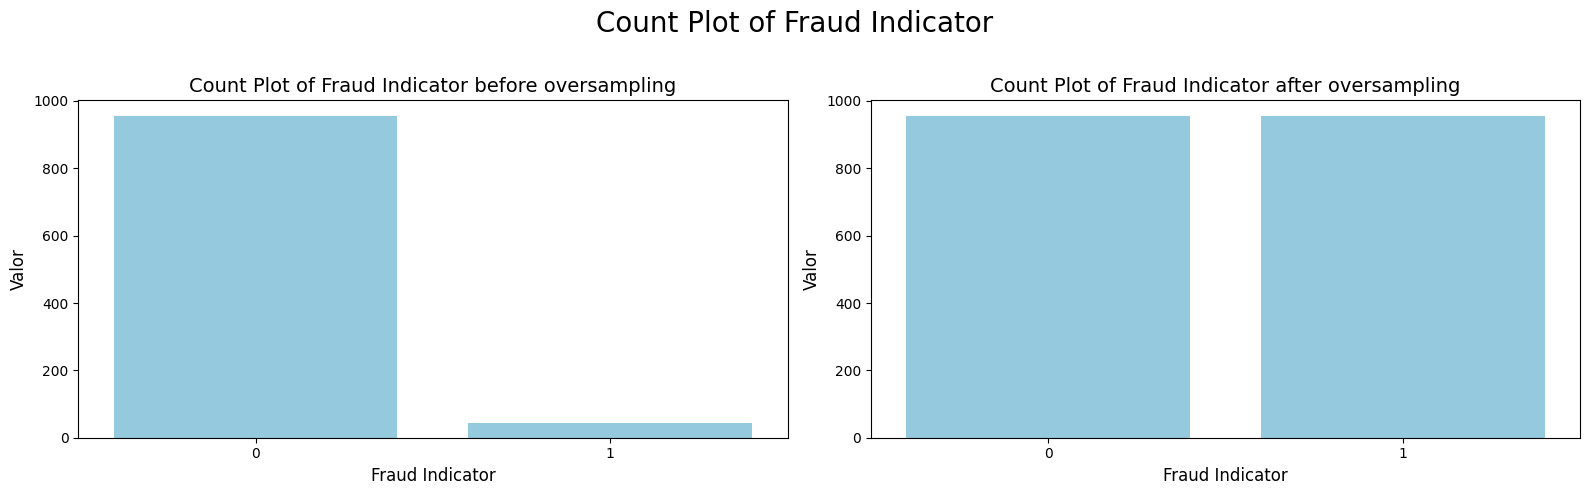

In [19]:
# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
x_resampled, y_resampled = smote.fit_resample(X, Y)

# Crear figura y subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axes = axes.flatten()  

# Box plot antes de oversampling
sns.countplot(data=pd.DataFrame({'FraudIndicator': Y}), x='FraudIndicator', color='skyblue', ax=axes[0])
axes[0].set_title('Count Plot of Fraud Indicator before oversampling', fontsize=14)
axes[0].set_xlabel('Fraud Indicator', fontsize=12)
axes[0].set_ylabel('Valor', fontsize=12)

# Box plot despues de oversampling
sns.countplot(data=pd.DataFrame({'FraudIndicator': y_resampled}), x='FraudIndicator', color='skyblue', ax=axes[1])
axes[1].set_title('Count Plot of Fraud Indicator after oversampling', fontsize=14)
axes[1].set_xlabel('Fraud Indicator', fontsize=12)
axes[1].set_ylabel('Valor', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.8)
fig.suptitle('Count Plot of Fraud Indicator', fontsize=20)
plt.show()


<div style="background-color:rgba(47, 83, 136, 0.75) ; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: white;">Modelado de datos</h1>
</div>


Configuracion MLFlow

In [20]:
# Configurar SQLite como backend store
#mlflow.set_tracking_uri("sqlite:///C:\Users\camil\OneDrive\Escritorio\Tesis\proyectos\main\services\mlflow/mlflow.db")



experiment_name = "Detección de fraude electrónico"
#mlflow.create_experiment(experiment_name, artifact_location="file:///C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/services/mlflow/artifacts")
mlflow.set_experiment(experiment_name)
mlflow.set_registry_uri("C:/Users/camil/OneDrive/Escritorio/Tesis/proyectos/main/services/mlflow/artifacts")

### Regresión logística

AttributeError: Line2D.set() got an unexpected keyword argument 'ax'

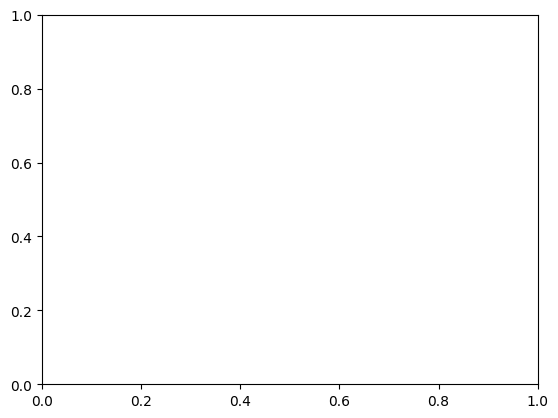

In [ ]:
# Validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_configs = [
    {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear'},
    {'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear'},
    {'penalty': 'l2', 'C': 0.1, 'solver': 'liblinear'},
    {'penalty': 'l2', 'C': 10, 'solver': 'liblinear'},
    {'penalty': 'l2', 'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'},
    {'penalty': 'l1', 'C': 0.5, 'solver': 'liblinear', 'class_weight': 'balanced'},
    {'penalty': 'l2', 'C': 1.0, 'solver': 'saga', 'max_iter': 500},
]

# params = {
   # "solver": "lbfgs",
  #  "max_iter": 100,
 #   "random_state": 42
#}

# Evaluar cada configuración
for i, params in enumerate(param_configs, 1):
    acc_acumulado, prec_acumulado, rec_acumulado, f1_acumulado, auc_acumulado, confusion_acumulado = [], [], [], [], [], []

    mean_fpr = np.linspace(0, 1, 100)
    tpr_acumulado = []
    aucs_acumulado = []

    # Validación cruzada con StratifiedKFold
    for fold, (train_idx, val_idx) in enumerate(skf.split(x_resampled, y_resampled)):

        # Dividir los datos en entrenamiento y validación
        x_train_temp = x_resampled.iloc[train_idx]
        y_train_temp = y_resampled.iloc[train_idx]
        x_val_temp = x_resampled.iloc[val_idx]
        y_val_temp = y_resampled.iloc[val_idx]

        # Entrenar el modelo
        model = LogisticRegression(**params)
        model.fit(x_train_temp, y_train_temp)

        # Predicciones
        y_pred_temp = model.predict(x_val_temp)
        y_proba_temp = model.predict_proba(x_val_temp)[:, 1]  # Probabilidades para clase positiva

        # Métricas de desempeño
        acc_acumulado.append(accuracy_score(y_val_temp, y_pred_temp))
        prec_acumulado.append(precision_score(y_val_temp, y_pred_temp, zero_division=0))
        rec_acumulado.append(recall_score(y_val_temp, y_pred_temp, zero_division=0))
        f1_acumulado.append(f1_score(y_val_temp, y_pred_temp, zero_division=0))
        auc = roc_auc_score(y_val_temp, y_proba_temp)
        auc_acumulado.append(auc)
        aucs_acumulado.append(auc)

        # Matriz de confusión
        confusion_acumulado.append(confusion_matrix(y_val_temp, y_pred_temp))

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_val_temp, y_proba_temp)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)  # Interpolación al eje común
        tpr_interp[0] = 0.0  # Garantizar que arranque en 0
        tpr_acumulado.append(tpr_interp)


    with mlflow.start_run(run_name=f"Logistic Regression {params}"):
        mlflow.log_params(params)
        
        mlflow.log_metric("accuracy", np.mean(acc_acumulado))
        mlflow.log_metric("precision", np.mean(prec_acumulado))
        mlflow.log_metric("recall", np.mean(rec_acumulado))
        mlflow.log_metric("f1_score", np.mean(f1_acumulado))
        mlflow.log_metric("roc_auc", np.mean(auc_acumulado))

        signature = infer_signature(x_val_temp, y_pred_temp)
        mlflow.sklearn.log_model(model, "model", signature=signature, input_example=x_val_temp.iloc[:1])

        # Crear figura y ejes
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
        axes = axes.flatten()

        # Calcular curva ROC
        mean_tpr = np.mean(tpr_acumulado, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs_acumulado)

        # Guardar curva ROC
        plt.figure()
        plt.plot(mean_fpr, mean_tpr, color='blue', label=f'ROC promedio (AUC = {mean_auc:.2f})', ax=axes[0])
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        axes[0].set_title('Curva ROC Promedio', fontsize=13)
        axes[0].set_xlabel('FPR', fontsize=11)
        axes[0].set_ylabel('TPR', fontsize=11)
        axes[0].tick_params(axis='x', rotation=30)
        axes[0].legend()
        plt.savefig("services/mlflow/figures/roc_curve_avg_rl.png")
        mlflow.log_artifact("services/mlflow/figures/roc_curve_avg_rl.png")

        # Guardar curva PR
        precision, recall, _ = precision_recall_curve(y_val_temp, y_proba_temp)
        plt.figure()
        plt.plot(recall, precision, ax=axes[1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.savefig("services/mlflow/figures/pr_curve_rl.png")
        mlflow.log_artifact("services/mlflow/figures/pr_curve_rl.png")

        plt.tight_layout()
        plt.show()

        mlflow.end_run()






### XGBoost

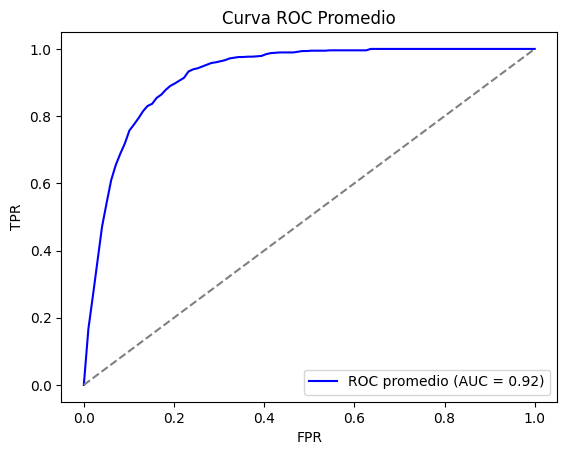

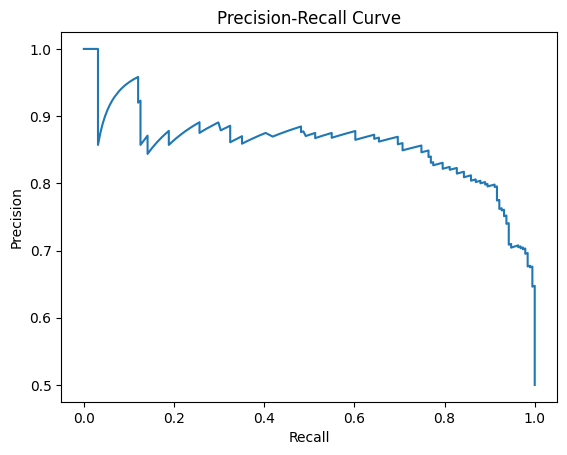

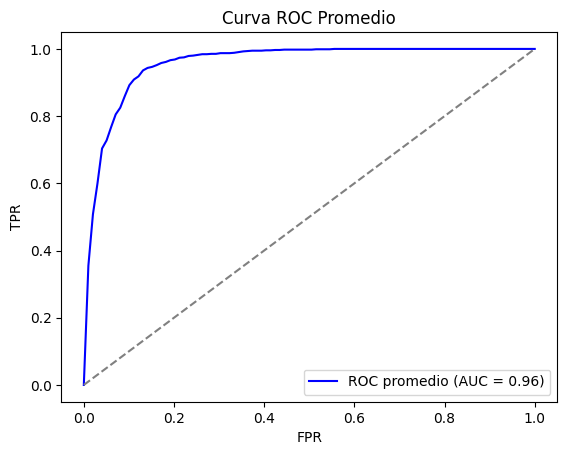

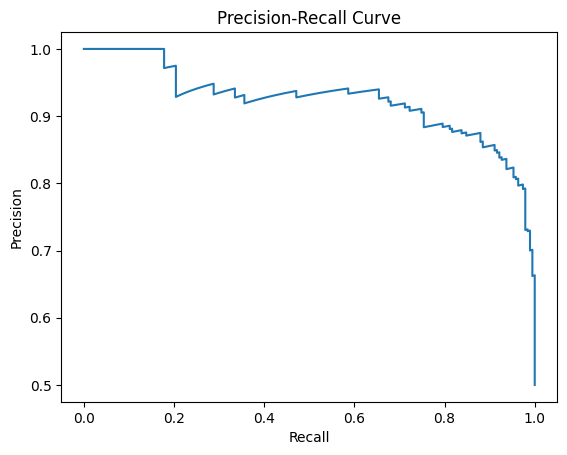

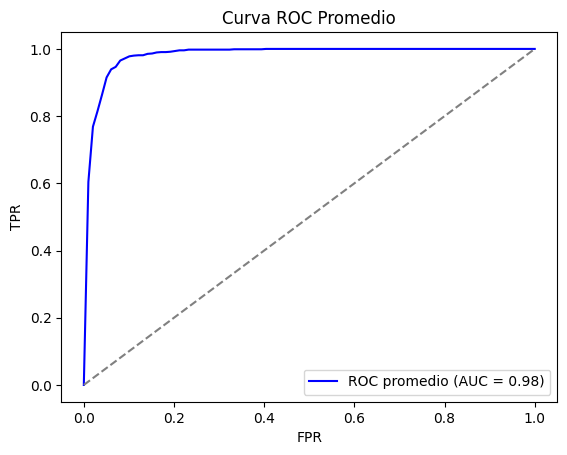

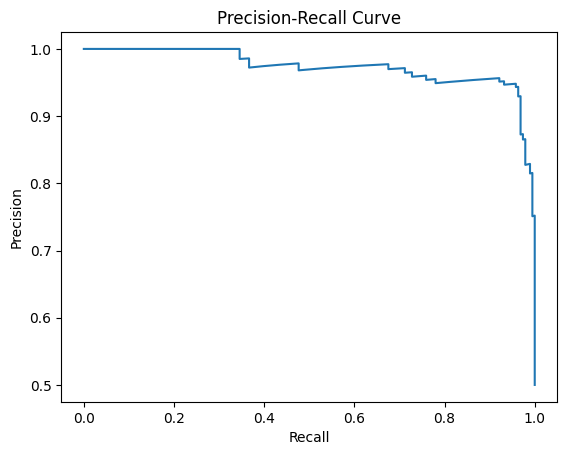

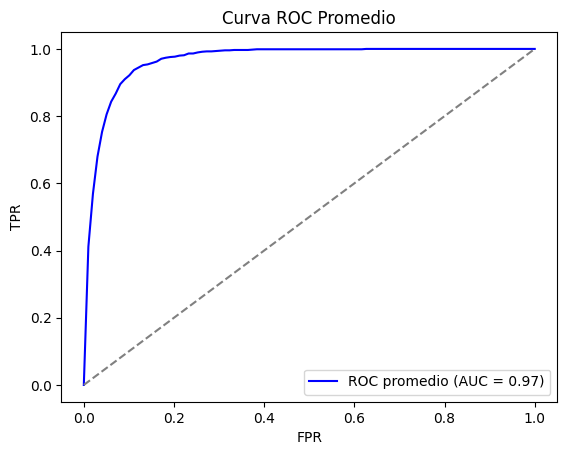

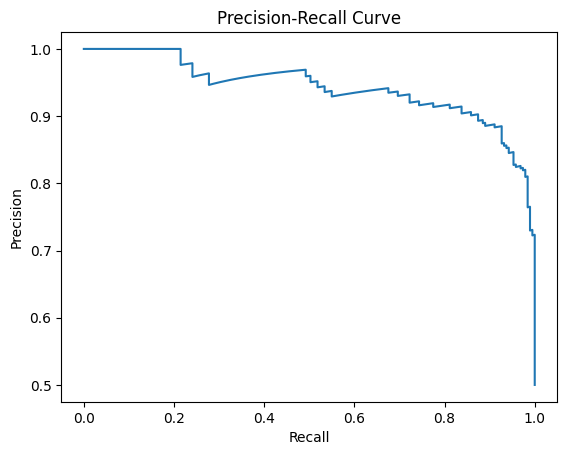

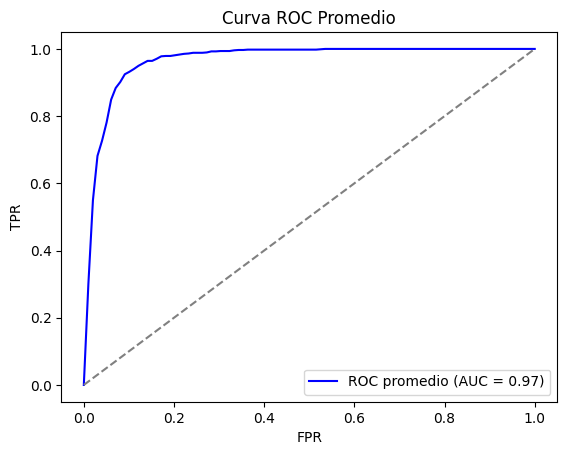

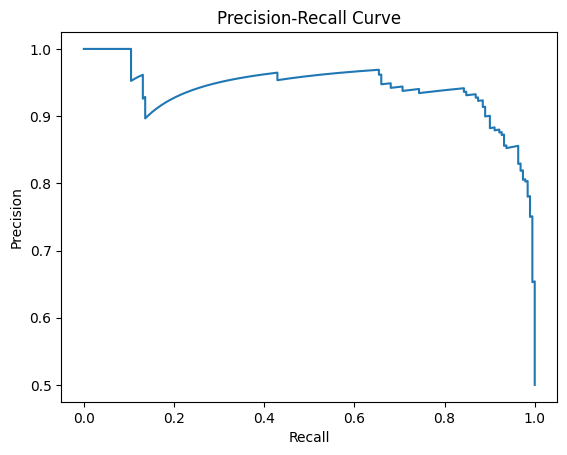

In [ ]:
# Validación cruzada
skf_xgboost = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_configs = [
    {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1, "subsample": 1, "colsample_bytree": 1, "use_label_encoder": False, "eval_metric": "logloss"},
    {"n_estimators": 200, "max_depth": 4, "learning_rate": 0.05, "subsample": 0.8, "colsample_bytree": 0.8, "use_label_encoder": False, "eval_metric": "logloss"},
    {"n_estimators": 100, "max_depth": 6, "learning_rate": 0.1, "subsample": 0.7, "colsample_bytree": 0.9, "scale_pos_weight": 2, "use_label_encoder": False, "eval_metric": "logloss"},
    {"n_estimators": 300, "max_depth": 5, "learning_rate": 0.03, "subsample": 0.9, "colsample_bytree": 0.7, "reg_alpha": 1, "reg_lambda": 1, "use_label_encoder": False, "eval_metric": "logloss"},
    {"n_estimators": 150, "max_depth": 3, "learning_rate": 0.2, "subsample": 0.85, "colsample_bytree": 0.75, "scale_pos_weight": 5, "use_label_encoder": False, "eval_metric": "logloss"}
]

# Evaluar cada configuración
for i, params in enumerate(param_configs, 1):
    acc_acumulado, prec_acumulado, rec_acumulado, f1_acumulado, auc_acumulado = [], [], [], [], []

    mean_fpr = np.linspace(0, 1, 100)
    tpr_acumulado = []
    aucs_acumulado = []

    # Validación cruzada
    for fold, (train_idx, val_idx) in enumerate(skf_xgboost.split(x_resampled, y_resampled)):
        x_train_temp = x_resampled.iloc[train_idx]
        x_val_temp = x_resampled.iloc[val_idx]
        y_train_temp = y_resampled.iloc[train_idx]
        y_val_temp = y_resampled.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(x_train_temp, y_train_temp)
        y_pred_temp = model.predict(x_val_temp)
        y_proba_temp = model.predict_proba(x_val_temp)[:, 1]

        # Métricas
        acc_acumulado.append(accuracy_score(y_val_temp, y_pred_temp))
        prec_acumulado.append(precision_score(y_val_temp, y_pred_temp))
        rec_acumulado.append(recall_score(y_val_temp, y_pred_temp))
        f1_acumulado.append(f1_score(y_val_temp, y_pred_temp))
        auc_acumulado.append(roc_auc_score(y_val_temp, y_proba_temp))
        # agregar confucion matrix? confusion = confusion_matrix(Y_test, y_pred)

        #curvas ROC, falta la otra curva
        fpr, tpr, _ = roc_curve(y_val_temp, y_proba_temp)
        tpr_acumulado.append(np.interp(mean_fpr, fpr, tpr))  # Interpola los puntos al mismo eje X
        tpr_acumulado[-1][0] = 0.0
        aucs_acumulado.append(roc_auc_score(y_val_temp, y_proba_temp))


    with mlflow.start_run(run_name=f"XGBoost {params}"):
        mlflow.log_params(params)
        
        mlflow.log_metric("accuracy", np.mean(acc_acumulado))
        mlflow.log_metric("precision", np.mean(prec_acumulado))
        mlflow.log_metric("recall", np.mean(rec_acumulado))
        mlflow.log_metric("f1_score", np.mean(f1_acumulado))
        mlflow.log_metric("roc_auc", np.mean(auc_acumulado))

        signature = infer_signature(x_val_temp, y_pred_temp)
        mlflow.sklearn.log_model(model, "model", signature=signature, input_example=x_val_temp.iloc[:1])

        # Guardar curva ROC
        mean_tpr = np.mean(tpr_acumulado, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs_acumulado)


        # Guardar curva ROC
        plt.figure()
        plt.plot(mean_fpr, mean_tpr, color='blue', label=f'ROC promedio (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Curva ROC Promedio')
        plt.legend()
        plt.savefig("services/mlflow/figures/roc_curve_avg_xgboost.png")
        mlflow.log_artifact("services/mlflow/figures/roc_curve_avg_xgboost.png")

        # Guardar curva PR
        precision, recall, _ = precision_recall_curve(y_val_temp, y_proba_temp)
        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.savefig("services/mlflow/figures/pr_curve_xgboost.png")
        mlflow.log_artifact("services/mlflow/figures/pr_curve_xgboost.png")

        mlflow.end_run()


## Red Neuronal

# Ranking Models perfromance
1. Random Forest Classifier
2. Gradient Boosting Algorithm
3. Decision Tree Classifier
4. K-Nearest Neighbours
5. Support Vector Machine (SVC)
6. Logistic Regression

Now we can HyperParameterTune the

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def evaluate_classification_models(X_resampled, y_resampled):
    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Define a dictionary of classification models
    models = {
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "Random Forest Classifier": RandomForestClassifier(),
        "Support Vector Machine (SVM)": SVC(),
        "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
        "Gradient Boosting Classifier": GradientBoostingClassifier()
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate and store various metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Confusion Matrix": confusion
        }
    
    return results

results = evaluate_classification_models(X_resampled, y_resampled)
for model_name, model_result in results.items():
     print(f"Results for {model_name}:")
     for metric, value in model_result.items():
         print(f"{metric}: {value}")
     print()


NameError: name 'X_resampled' is not defined

## RandomForest CLassifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Define a range of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the resampled data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Train the best model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate and print various metrics to evaluate the best model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Best Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Escalar los datos (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear la red neuronal
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32)

# Evaluar
accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy (DNN):", accuracy[1])

Epoch 1/20
39/39 [==============================] - 2s 20ms/step - loss: 0.6612 - accuracy: 0.5998 - val_loss: 0.6228 - val_accuracy: 0.6634
Epoch 2/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6174 - accuracy: 0.6612 - val_loss: 0.5855 - val_accuracy: 0.7320
Epoch 3/20
39/39 [==============================] - 0s 8ms/step - loss: 0.5815 - accuracy: 0.6948 - val_loss: 0.5562 - val_accuracy: 0.7288
Epoch 4/20
39/39 [==============================] - 0s 7ms/step - loss: 0.5572 - accuracy: 0.7111 - val_loss: 0.5436 - val_accuracy: 0.7516
Epoch 5/20
39/39 [==============================] - 0s 6ms/step - loss: 0.5496 - accuracy: 0.7300 - val_loss: 0.5138 - val_accuracy: 0.7614
Epoch 6/20
39/39 [==============================] - 0s 5ms/step - loss: 0.5139 - accuracy: 0.7635 - val_loss: 0.5066 - val_accuracy: 0.7745
Epoch 7/20
39/39 [==============================] - 0s 6ms/step - loss: 0.5014 - accuracy: 0.7643 - val_loss: 0.4915 - val_accuracy: 0.7745
Epoch 8/20
39/39 [=

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest
y_pred_rf = best_rf_model.predict(X_test)
print("Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

# Red Neuronal
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Neural Network Metrics:")
print(classification_report(y_test, y_pred_nn))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nn))


Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       197
           1       0.86      0.99      0.92       185

    accuracy                           0.92       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.93      0.92      0.92       382

ROC-AUC: 0.9184524626148992
12/12 [==============================] - 0s 2ms/step
Neural Network Metrics:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       197
           1       0.74      0.95      0.83       185

    accuracy                           0.82       382
   macro avg       0.84      0.82      0.81       382
weighted avg       0.84      0.82      0.81       382

ROC-AUC: 0.8208533406502951
